In [35]:
import pandas as pd
import numpy as np
import gensim
import nltk
import datetime
import time
import pickle
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel,Phrases
from gensim.models.phrases import Phraser
from gensim.models import word2vec
from nltk import word_tokenize
from nltk.tag import StanfordNERTagger 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(1960)

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [144]:
movies1_df = pd.read_json('data/eng_1_430.json')
movies2_df = pd.read_json('data/eng_431_601.json')
movies = movies1_df.append(movies2_df)
print(movies.shape)
movies.head()

(56005, 2)


,summary,title
0,nown as 1 Life On The Limit is a 2013 document...,1 (2013 film)
1,While on the phone with his girlfriend Jill w...,+1 (film)
10,Gully Mercer Mick Rossi leads a group of prol...,2:22 (2008 film)
100,o Christmas is a Ghanaian drama movie about Re...,6 Hours To Christmas
1000,r is a 1995 American romantic drama television...,The Affair (1995 film)


In [ ]:
movies.shape

In [ ]:
import random
sample = random.sample(list(movies['summary']),25000)
sample1 = sample[:12501]
sample2 = sample[12501:]
sample3 = list(movies['summary'])[30000:45001]
sample4 = list(movies['summary'])[45000:]

In [165]:
titles = movies.loc[movies['summary'].isin(sample)]
len(titles)

25002

In [166]:
titles = titles[(titles.title != 'Island of Death (film)') & (titles.title != "God's Clay (1919 film)")]

In [ ]:
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz',
                       '/Users/alexanderbailey/Documents/stanford-ner-2018-10-16/stanford-ner.jar')
#names2 = tag_words(sample2, st)

In [132]:
list(names)[:10]
len(names.union(set(map(lambda x: x.lower(),names))))

113746

In [ ]:
# with open('data/names_list1.pkl', 'wb') as f:
#     pickle.dump(names, f)

In [101]:
#st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz',
#                        '/Users/alexanderbailey/Documents/stanford-ner-2018-10-16/stanford-ner.jar')
#names = tag_words(list(movies['summary']))
with open('data/names_list1.pkl', 'rb') as f1:
    names1 = pickle.load(f1)
with open('data/names_list2.pkl', 'rb') as f2:
    names2 = pickle.load(f2)
    
names = set(names1).union(set(names2))

In [131]:
names = names.union(set(map(lambda x: x.lower(),names)))
stop_words = stopwords.words('english')
stop_words += ['film', 'directed', 'film_directed', 'series',
               'story', 'american', 'starring', 'films', 'direct',
               'produced', 'stars', 'released','premiered','features',
              'featuring','interviews','release','version','performances',
              'performance','perform','titled','title','distributed','featured',
              'adaptation','character','role','including']
# different, bands, performances, titled, ideas, significant, musicians, issue, perform, performed, 
# Topic 12: 
# role, including, shown, debut, character, september, distributed, adaptation, november, featured, 
stop_words = set(stop_words).union(names)

In [217]:
def get_tag(idx,doc,st):
    if idx % 1000:
        print(idx)
        return st.tag(doc.split())

def tag_words(texts, st):
    tags = [get_tag(idx,doc,st) for idx,doc in enumerate(texts)]
    names = [set([word for word,tag in doc if tag != 'O']) for doc in tags]
    return set.union(*names)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def remove_sw(doc):
    return [word for word in simple_preprocess(str(doc)) if word not in stop_words]

def get_single_corpus(doc,id2word):
    words = remove_sw(doc)
    bigram_mod = bigrams(words)
    bigram = bigram_mod[words]
    corpus = id2word.doc2bow(bigram)
    return corpus

def bigrams(words, bi_min=15, tri_min=10):
    bigram = Phrases(words, min_count = bi_min)
    bigram_mod = Phraser(bigram)
    return bigram_mod

def refactor_corpus(bigram):
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=15, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word

def get_corpus(df):
    #words = list(df['summary'])
    words = remove_stopwords(df)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[plot] for plot in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=15, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [133]:
now = datetime.datetime.now()
m_corpus, m_id2word, bigram = get_corpus(sample)
later = datetime.datetime.now()
elapsed = later-now
print("Time: ", elapsed)

Time:  0:00:19.972509


In [ ]:
# with open('samples.pkl','wb') as f:
#     pickle.dump([m_corpus,m_id2word,sample,sample1,sample2],f)

In [36]:
# with open('samples.pkl','rb') as f:
#     data = pickle.load(f)
# m_corpus = data[0]
# m_id2word = data[1]
# sample = data[2]
# sample1 = data[3]
# sample2 = data[4]

In [ ]:
dictionary  = gensim.corpora.Dictionary(processed_docs)

count = 0
for k, v in dictionary.iteritems():
    count += 1
    if count > 10:
        break

In [ ]:
dictionary.filter_extremes(no_below=20, no_above=0.5, keep_n=100000)

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [ ]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


In [ ]:
hdp_model = gensim.models.HdpModel(corpus=m_corpus, id2word=m_id2word, random_state=56)


In [ ]:
for idx, topic in hdp_model.print_topics(num_topics=-1, num_words=5):
    print('Topic : {} Word: {}'.format(idx, topic))

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=m_corpus,
                                       num_topics=20,
                                       id2word=m_id2word,
                                       chunksize=100,
                                       eval_every=1,
                                       per_word_topics=True,
                                       passes=20,
                                       workers=4)

for idx, topic in lda_model.print_topics(num_topics=-1):
    print('Topic : {} Word: {}'.format(idx, topic))

0: Medical/Academic
1: 
2: Dramatic Thriller
3: Romance
4: Family
5: Political Trhiller
6: Acting/Musicians
7: Violence/War

In [204]:
coherence_values = []
model_list = []
for num_topics in range(5,10,1):
    model = gensim.models.LdaMulticore(corpus=m_corpus,
                                       num_topics=num_topics,
                                       id2word=m_id2word,
                                       chunksize=100,
                                       eval_every=1,
                                       per_word_topics=True,
                                       passes=20,
                                       workers=3)
    model_list.append(model)
    
    coherencemodel = CoherenceModel(model=model, 
                                    texts=bigram,
                                    dictionary=m_id2word,
                                   coherence='c_v')
    print('model with ' + num_topics + ' topics')
    coherence_values.append(coherencemodel.get_coherence())

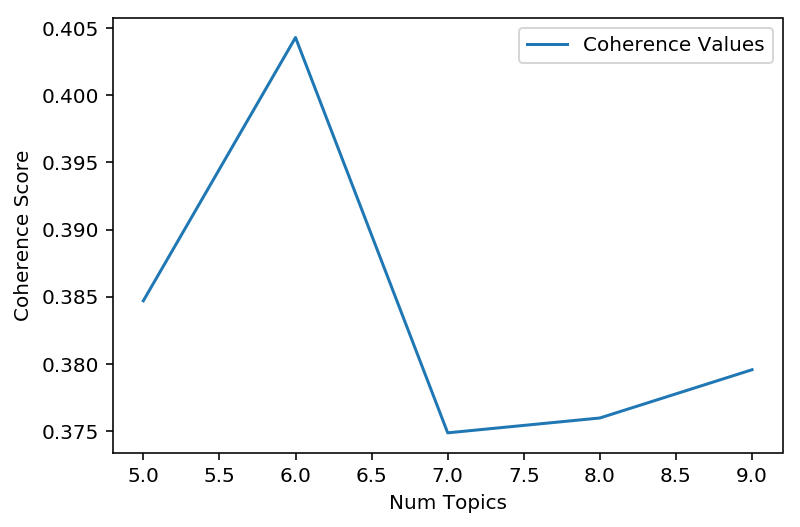

In [206]:

X = np.arange(5,10,1)

fig, ax = plt.subplots()
ax.plot(X, coherence_values, label="Coherence Values")
ax.set_xlabel('Num Topics')
ax.set_ylabel('Coherence Score')
plt.legend()
plt.show()

In [207]:
for m, cv in zip(X, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3847
Num Topics = 6  has Coherence Value of 0.4043
Num Topics = 7  has Coherence Value of 0.3749
Num Topics = 8  has Coherence Value of 0.376
Num Topics = 9  has Coherence Value of 0.3796


In [197]:
models2 = model_list
coherence2 = coherence_values

In [209]:
for topic in range(6):
    print('Topic ' + str(topic) + ': ')
    for word in range(10):
        print(model_list[1].show_topic(topic)[word][0] + ", ", end="")
    print('')


Topic 0: 
killed, reveals, named, captured, plan, led, attempt, others, attempts, manages, 
Topic 1: 
begins, causing, uses, attempts, causes, rope, turns, onto, precode, open, 
Topic 2: 
tries, leave, runs, killed, begins, starts, apartment, turns, attempts, named, 
Topic 3: 
played, th, shown, includes, final, debut, received, career, romantic, writer, 
Topic 4: 
decides, meets, relationship, become, would, begins, agrees, makes, gives, leave, 
Topic 5: 
ship, plane, flight, pilot, passengers, ships, launch, engine, lands, available, 


### Topics 1

Topic 0: War
ship, plane, bomb, pilot, flight, helicopter, passengers, ships, surface, launch, 
Topic 1: Books/Based on Book
th, shown, received, final, debut, played, september, career, inspired, writer, 
Topic 2: Prison
map, starred, prisoners, wallet, era, inmates, produce, wins, plague, arrange, 
Topic 3: Espionage
killed, reveals, named, attempts, discovers, discover, others, attacked, taken, attempt, 
Topic 4: Drama
apartment, plan, meets, killed, pay, agrees, tries, arrest, turns, named, 
Topic 5: Romance
relationship, decides, begins, meets, become, would, leave, married, gives, makes, 
Topic 6: 
played, concerns, focuses, romantic, roles, includes, screened, bands, appeared, composed, 
Topic 7: 
tries, runs, starts, begins, leave, turns, makes, causing, bed, attempts, 

### Topics 2

Topic 0: Crime Drama
tape, killed, cop, thugs, involved, arrest, led, dealer, attempts, become,

Topic 1: On the Run
tries, begins, runs, leave, attempts, turns, starts, causing, try, named, 

Topic 2: Flight Thriller
plane, flight, pilot, passengers, infected, aired, bombing, engine, airplane, climbing,

Topic 3: Murder Mystery
killed, reveals, discovers, murdered, died, claims, apartment, evidence, begins, investigate,

Topic 4: Relationship Drama
th, played, includes, concerns, september, received, romantic, shown, november, december, 

Topic 5: Heist
plan, named, plans, scheme, fake, pay, minister, thief, hired, turns, 

Topic 6: Jail
trial, sent, prisoners, execution, sentenced, taken, lawyer, guilty, sentence, member, 

Topic 7: Highschool
contract, script, paying, prom, championship, teams, composer, involves, debate, current, 

Topic 8: Romance
relationship, become, begins, decides, must, would, yearold, seems, married, career, 

Topic 9: Action
killed, ship, reveals, captured, attempt, bomb, led, remaining, others, plan, 

Topic 10: Decisions
leave, meets, decides, gives, agrees, tries, makes, apartment, offers, reveals, 

Topic 11: Hospital
debut, shown, patients, called, narrator, starred, composed, appeared, available, patient,

In [139]:
topic_vecs = []
for i in range(len(sample)):
    top_topics = model_list[2].get_document_topics(m_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(12)]
    topic_vecs.append(topic_vec)

In [227]:
unseen = 'As people are enjoying drinks in a bar, a man covered in blood—identified onscreen as "Hero" '
unseen += '(Eric Dane)—enters through the door and warns them all of impending danger. No one heeds his warning, '
unseen += 'so he shows the bar patrons the head of a repulsive creature to make them take him seriously. He is soon '
unseen += 'pulled through a window and decapitated by one of the monsters. After the carnage, a woman—"Heroine" '
unseen += '(Navi Rawat)—bursts through the door and reveals herself to be the recently deceased mans wife. After a brief '
unseen += 'sentimental moment between the wife and her late husband, the bar patrons begin boarding up the windows in '
unseen += 'the bar. Despite their efforts, a young monster bursts through an uncovered window and begins attacking. As a '
unseen += 'monster outside bursts its hand through "Vet" (Anthony "Treach" Criss), "Edgy Cat" (Jason Mewes) has his face '
unseen += 'torn off and is accidentally shot dead, and the little monster cuts off the leg of one of the women — "Harley Mom" '
unseen += ' (Diane Ayala Goldner)—who is initially assumed to have died from massive blood loss. The monster disappears '
unseen += 'for some time, then is found attempting to sexually penetrate one of the deer heads nailed to the wall. '
unseen += 'A shotgun blast removes the deer head and monster. The monster drops into a freezer which is then sealed shut, '
unseen += 'trapping it inside. Following this, the remaining windows are boarded up and the bar patrons are given a moment '
unseen += 'of peace. Trying to call for help, they learn that the only phone in the bar has been hit by a stray shotgun '
unseen += 'blast and rendered useless. One of the women—"Tuffy" (Krista Allen)—suddenly realizes that her son Cody '
unseen += '(Tyler Patrick Jones) is still upstairs and runs to get him. Once she finds her child the group rejoices '
unseen += 'until the boy is pulled through a window and eaten by one of the monsters, leaving only his right foot behind.'
unseen += ' Tuffy is incapacitated by grief, while the monster vomits a stream of slime at one of the group—"Beer Guy" '
unseen += '(Judah Friedlander). As the remaining people regroup downstairs, they realize that the slime has a decomposing'
unseen += ' effect and that Beer Guy is being slowly overcome by its effects.'

corp = get_single_corpus(unseen,m_id2word)

topic = models2[2].get_document_topics(corp, minimum_probability=0.0)
idx, scores = zip(*topic)
topic_names[scores.index(max(scores))]

'On the Run'

In [140]:
topic_vecs[0]

[0.00087786873,
 0.16741757,
 0.0008778598,
 0.00087787234,
 0.0008778833,
 0.16576791,
 0.00087788934,
 0.0008778703,
 0.19216758,
 0.45579526,
 0.00087789266,
 0.012706535]

In [ ]:
topic = topic_vecs[0].index(max(topic_vecs[0]))

### Extracting Target

In [141]:
# topic_names = ['Crime Drama','On the Run','Thriller involving Planes','Murder Mystery','Relationship Drama',
#                'Heist','Jail','Highschool','Romance','Action',
#                'Tough Decisions','Hospitals']
topic_names = []
topics_numbered = {t:idx for idx,t in enumerate(topic_names)}
topics_numbered

{'Crime Drama': 0,
 'On the Run': 1,
 'Thriller involving Planes': 2,
 'Murder Mystery': 3,
 'Relationship Drama': 4,
 'Heist': 5,
 'Jail': 6,
 'Highschool': 7,
 'Romance': 8,
 'Action': 9,
 'Tough Decisions': 10,
 'Hospitals': 11}

In [147]:
topic_nums = [vec.index(max(vec)) for vec in topic_vecs]
topics = np.array([topic_names[topic] for topic in topic_nums])
len(topics)

25000

In [167]:
df_movies = titles.copy()
df_movies.loc[:,'label'] = topics
df_movies = df_movies.reset_index()
df_movies = df_movies.drop('index',axis=1)
df_movies.head()
#df_movies.to_json('labeled_movies.json')

### Word Embedding

In [168]:
#df_movies = pd.read_json('labeled_movies.json')
texts = df_movies['summary']
total_vocabulary = set(word for summary in texts for word in summary)

In [169]:
df_movies['label'] = df_movies['label'].map(topics_numbered)
df_movies.head()

,summary,title,label
0,While on the phone with his girlfriend Jill w...,+1 (film),9
1,Gully Mercer Mick Rossi leads a group of prol...,2:22 (2008 film),3
10,Dyan Cannon plays Madie Levrington a wealthy ...,Coast to Coast (1980 film),3
100,Gallery owner Farnsworth takes a painting out...,Color Me Blood Red,10
1000,Daffy is taking a bubble bath in a pond when ...,Ain't That Ducky,1


In [170]:
labels = df_movies['label']

In [4]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [5]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [190]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

vectorizer = CountVectorizer()
vectorizer.fit(df_movies['summary'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

## Classification Model

In [194]:
rf =  Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ('Support Vector Machine', SVC(gamma='auto'))])
lr = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression(solver='lbfgs',max_iter=1000,multi_class='auto'))])
xgb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('XGBoost',XGBClassifier(n_estimators=100))])

In [172]:
tokenized_text = df_movies['summary'].map(word_tokenize).values

In [195]:
models = [('Random Forest', rf),
          ("Support Vector Machine", svc),
          ("Logistic Regression", lr),
          ('XGBoost', xgb)]
scores = [(name, cross_val_score(model, tokenized_text, labels, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [193]:
scores

[('Random Forest', 0.13920021921793263),
 ('Support Vector Machine', 0.16123999968742397),
 ('Logistic Regression', 0.13039960431101721),
 ('XGBoost', 0.1518795191482603)]

In [176]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [177]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(df_movies.summary))
list_tokenized_headlines = tokenizer.texts_to_sequences(df_movies.summary)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=500)
y = pd.get_dummies(labels).values

In [181]:
embedding_size = 128
input_ = Input(shape=(500,))
x = Embedding(20000, embedding_size)(input_)
x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# There are 41 different possible classes, so we use 41 neurons in our output layer
x = Dense(12, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

In [182]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [183]:
model.fit(X_t, y, epochs=5, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 672s 34ms/step - loss: 2.3254 - acc: 0.1442 - val_loss: 2.2785 - val_acc: 0.1630
Epoch 2/5
20000/20000 [==============================] - 649s 32ms/step - loss: 2.2929 - acc: 0.1515 - val_loss: 2.2801 - val_acc: 0.1630
Epoch 3/5
20000/20000 [==============================] - 658s 33ms/step - loss: 2.2779 - acc: 0.1575 - val_loss: 2.2844 - val_acc: 0.1634
Epoch 4/5
20000/20000 [==============================] - 628s 31ms/step - loss: 2.2435 - acc: 0.1683 - val_loss: 2.3048 - val_acc: 0.1588
Epoch 5/5
20000/20000 [==============================] - 643s 32ms/step - loss: 2.1740 - acc: 0.1878 - val_loss: 2.3558 - val_acc: 0.1440


In [91]:
df_movies.summary.apply(lambda x: len(x))

1386.0223982081434